In [1]:
import json
import pandas as pd
import ast
import datetime
from tabulate import tabulate
from misc import display, convert_unixtime, convert_country_code, cut, copy_rename, get_slice, calculate_percentages
from misc import extract_relationship, extract_education, extract_group, agebuckets, expand, get_item
import folium
from folium import plugins

In [2]:
#infile = "collections/devices/dataframe_collected_finished_1533128653.csv.gz" # 01-08
#infile = "./collections/devices/dataframe_collected_finished_1533133112.csv.gz" # 
#infile = "./collections/devices/dataframe_collected_finished_1533199943.csv.gz"
#infile = "collections/devices/dataframe_collected_finished_1533208943.csv.gz"
#infile = "collections/devices/dataframe_collected_finished_1533473021.csv.gz"
#infile = "collections/devices/dataframe_collected_finished_1533558042.csv.gz"
#infile = "collections/devices/dataframe_collected_finished_1533586093.csv.gz" # includes Galaxy S9
# ...
infile = "collections/devices/dataframe_collected_finished_1543768104.csv.gz"

df = pd.read_csv(infile)

useInfra = True
useWifi = True
train_frequency = "mau"

#df["CollectionDay"] = df["timestamp"].apply(lambda x: convert_unixtime(x))
#print("Collection made in %s" % (df["CollectionDay"].head()[0]))

gdp = pd.read_csv("./gdp_nominal.csv")  # https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)_per_capita
#gdp = pd.read_csv("./gdp_ppp.csv")       # https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(PPP)_per_capita

In [3]:
def transform_dataframe(df):
    df[["MinAge","MaxAge","Location","LocationHierarchy","LocationType","Gender","Relationship","Education","Group"]] = df["targeting"].apply(lambda x : expand(ast.literal_eval(x))).apply(pd.Series)

    if "citizenship" in df:
        df["Group"] = df["citizenship"].fillna("[]").apply(lambda x : get_item(ast.literal_eval(x)))
        print("Updating Group information...")

    if "access_device" in df:
        df["Device"] = df["access_device"].fillna("[]").apply(lambda x : get_item(ast.literal_eval(x)))
        print("Adding information regarding devices...")
    else:
        df["Device"] = None

    df["AgeBucket"] = df[["MinAge","MaxAge"]].apply(lambda x: agebuckets(x["MinAge"], x["MaxAge"]), axis=1)

    print("Removing redundant cols")
    for col in ["Unnamed: 0", "all_fields", "targeting",'behavior', 'citizenship', "mock_response", "access_device", 
                "ages_ranges", "household_composition", 'interests', 'family_statuses', 'genders', 'geo_locations', 'languages',
                'name', 'relationship_statuses', 'response', 'scholarities', 'timestamp', 'publisher_platforms',]:
        if col in df.keys():
            del df[col]

    print("All Done!")

transform_dataframe(df)
    
main_devices = ["Expensive Devices", "Mid-range Devices", "Cheap Devices", "Other Devices"]

if useInfra:
    devices = ["Expensive Devices", "Mid-range Devices", "Cheap Devices", "Other Devices", "2G", "3G", "4G", "Wifi"]
    if useWifi:
        infra = ["2G", "3G", "4G", "Wifi"]
    else:
        infra = ["2G", "3G", "4G"]
        
else:
    devices = ["Expensive Devices", "Mid-range Devices", "Cheap Devices", "Other Devices"]
# Brief description: 
# -----------------
# Gender: 0 Both, 1 Man, 2 Woman
# Age: 13-Null, 13-18, 19-25, 26-40, 41-65, 65+
# LocationType: home_recent, home, recent


Adding information regarding devices...
Removing redundant cols
All Done!


In [4]:
dfdevices = {}
dfcut = df[(df["Device"].apply(lambda x : x in main_devices)) & (df["AgeBucket"] == "all") & (df["LocationType"] == "home_recent")].copy()
dfdevices["mau"] = get_slice(dfcut, "Device", main_devices, frequency="mau")
dfdevices["dau"] = get_slice(dfcut, "Device", main_devices, frequency="dau")
calculate_percentages(dfdevices["mau"], main_devices, "%")
calculate_percentages(dfdevices["dau"], main_devices, "%")

freq = dfdevices[train_frequency]
#print(freq.sort_values("Location").to_csv(index=False, sep="\t"))
freq["devices_pop"] = freq["audience_Expensive Devices"] + freq["audience_Mid-range Devices"] + freq["audience_Other Devices"] + freq["audience_Cheap Devices"]

merged = pd.merge(freq, gdp)

In [5]:
if useInfra:
    dfinfra = {}
    dfcut = df[(df["Device"].apply(lambda x : x in infra)) & (df["AgeBucket"] == "all") & (df["LocationType"] == "home_recent")].copy()
    dfinfra["mau"] = get_slice(dfcut, "Device", infra, frequency="mau")
    dfinfra["dau"] = get_slice(dfcut, "Device", infra, frequency="dau")
    calculate_percentages(dfinfra["mau"], infra, "%")
    calculate_percentages(dfinfra["dau"], infra, "%")

    freq = dfinfra[train_frequency]
    #print(freq.sort_values("Location").to_csv(index=False, sep="\t"))
    #freq["devices_pop"] = freq["audience_Expensive Devices"] + freq["audience_Mid-range Devices"] + freq["audience_Other Devices"] + freq["audience_Cheap Devices"]
    if useWifi:
        freq["infra_pop"] = freq["audience_2G"] + freq["audience_3G"] + freq["audience_4G"] + freq["audience_Wifi"]
    else:
        freq["infra_pop"] = freq["audience_2G"] + freq["audience_3G"] + freq["audience_4G"] 

    merged = pd.merge(freq, merged)

In [6]:
# Remove sparse locations
print("Before Removing locations: ", merged.shape[0])
for d in devices:
    merged = merged[merged["audience_" + d] > 2000]
    
merged.sort_values(by="gdp", ascending=False)

print("Locations Used: ", merged.shape[0])
#merged = merged[merged["total"] > 1000000]
#print "Locations Used: ", merged.shape[0]

('Before Removing locations: ', 186)
('Locations Used: ', 143)


In [7]:
population = pd.read_csv("population.csv")
population

merged = pd.merge(population,merged)

merged["%pop_online"] = merged["devices_pop"] / merged["pop2017"]
merged["lgdp"] = np.log(merged["gdp"])

postfilter = merged.copy()

In [8]:
postfilter = merged.copy()
#postfilter = postfilter[postfilter["%pop_online"] >= 0.1]
#postfilter = postfilter[postfilter["devices_pop"] > 10000000]

In [9]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_validation import LeaveOneOut
from sklearn import metrics

#X = postfilter[["%audience_Expensive Devices","%audience_Mid-range Devices","%audience_Cheap Devices"]].values
#X = postfilter[["%audience_Expensive Devices"]].values
#X = postfilter[["%audience_Other Devices"]].values

#X = postfilter[["%audience_Other Devices", "%audience_Expensive Devices", "%audience_Mid-range Devices", "%audience_Cheap Devices"]].values
#X = postfilter[["%audience_Other Devices", "%audience_Expensive Devices", "%audience_Mid-range Devices", "%audience_3G", "%audience_4G"]].values
X = postfilter[["%audience_Other Devices", "%audience_Expensive Devices", "%audience_Mid-range Devices", "%audience_Cheap Devices", "%audience_Wifi", "%audience_2G", "%audience_3G", "%audience_4G"]].values

#y = postfilter["gdp"].values
#y = postfilter["gdp"].values
y = postfilter["lgdp"].values
names = postfilter["Location"].values

loo = LeaveOneOut(X.shape[0])
results = []

for train_index, test_index in loo:
    model = LinearRegression(fit_intercept=True)
    #model = Ridge(alpha = .5)
    model = Lasso()
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)

    p = model.predict(X_test)
    results.append({"Location":names[test_index][0], "y":y_test[0], "pred":p[0], "epred":np.exp(p[0])})
    
results = pd.DataFrame(results)
r2 = metrics.r2_score(results["pred"], results["y"])
mae = metrics.mean_absolute_error(results["pred"], results["y"])

exp_r2 = metrics.r2_score(np.exp(results["pred"]), np.exp(results["y"]))
exp_mae = metrics.mean_absolute_error(np.exp(results["pred"]), np.exp(results["y"]))

countries = postfilter.shape[0]

print("MAE: ", mae)
print("EXP MAE: ", exp_mae)

print("R2: ", r2)
print("EXP R2: ", exp_r2)


print("Rows before: %d" % (postfilter.shape[0]))
results = pd.merge(results[["Location","pred","epred"]], postfilter)
#results["pred"] = np.exp(results["pred"])
results["pred"] = results["pred"]
print("Rows after: %d" % (results.shape[0]))

model = Lasso()
model.fit(X,y)
print("Coeficients:",model.coef_)

# EXP R2:  0.6489713043444731 dau "%audience_Other Devices"
# EXP R2:  0.5968156054192004 dau "%audience_Expensive Devices","%audience_Mid-range Devices","%audience_Cheap Devices"
# EXP R2:  0.4328638254512106 dau "%audience_Expensive Devices"
# EXP R2:  0.5177632565298602 dau "%audience_Mid-range Devices"
# EXP R2:  -3.5516473906171786 dau "%audience_Cheap Devices"
# EXP R2:  0.5756193120607576 dau "%audience_Cheap Devices", "%audience_Expensive Devices"
# EXP R2:  0.6268026326200818 dau "%audience_Cheap Devices", "%audience_Other Devices"
# EXP R2:  0.6153709589469156 dau "%audience_Expensive Devices", "%audience_Other Devices"
# EXP R2:  0.6393959763847079 dau "%audience_Mid-range Devices", "%audience_Other Devices"

('MAE: ', 0.5059749167398709)
('EXP MAE: ', 4714.044753792179)
('R2: ', 0.6914476611728492)
('EXP R2: ', 0.6610203474823182)
Rows before: 142
Rows after: 142
('Coeficients:', array([-0.02004297,  0.        ,  0.        ,  0.        ,  0.01508951,
       -0.        , -0.02357668,  0.00184325]))


/home/palotti/p2/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
results.corr("pearson")

,pred,epred,poprank,pop2017,audience_2G,audience_3G,audience_Wifi,audience_4G,%audience_2G,%audience_3G,...,audience_Other Devices,audience_Cheap Devices,%audience_Expensive Devices,%audience_Mid-range Devices,%audience_Cheap Devices,%audience_Other Devices,devices_pop,gdp,%pop_online,lgdp
pred,1.000000,0.861525,-0.006199,0.072226,-0.181164,-0.109770,0.342579,0.224665,-0.601499,-0.964904,...,0.070732,0.356919,0.829421,0.809201,0.632344,-0.849112,0.180539,0.804629,0.631578,0.881090
epred,0.861525,1.000000,-0.097596,0.026284,-0.192805,-0.169869,0.365424,0.198913,-0.429477,-0.751160,...,-0.003571,0.390445,0.929887,0.841805,0.594547,-0.898348,0.146939,0.882708,0.440939,0.758542
poprank,-0.006199,-0.097596,1.000000,-0.387688,-0.487342,-0.543011,-0.390338,-0.370851,-0.126382,0.027215,...,-0.426542,-0.451404,-0.023674,0.118019,0.198050,-0.082614,-0.470220,0.056186,0.271045,0.132444
pop2017,0.072226,0.026284,-0.387688,1.000000,0.492601,0.365326,0.214045,0.633405,-0.046812,-0.130082,...,0.658055,0.259870,0.060237,-0.055917,-0.156242,0.032796,0.617982,-0.048129,-0.179547,-0.027824
audience_2G,-0.181164,-0.192805,-0.487342,0.492601,1.000000,0.832765,0.193913,0.559878,0.187131,0.113551,...,0.781005,0.248359,-0.255507,-0.304880,-0.279192,0.303458,0.675310,-0.213789,-0.112512,-0.207131
audience_3G,-0.109770,-0.169869,-0.543011,0.365326,0.832765,1.000000,0.334535,0.493738,-0.035825,0.044324,...,0.739009,0.398391,-0.233516,-0.268814,-0.221762,0.264627,0.669290,-0.196676,0.048393,-0.126107
audience_Wifi,0.342579,0.365424,-0.390338,0.214045,0.193913,0.334535,1.000000,0.620152,-0.199599,-0.311120,...,0.419493,0.944665,0.325839,0.227406,0.135135,-0.272323,0.681471,0.290452,0.238780,0.285365
audience_4G,0.224665,0.198913,-0.370851,0.633405,0.559878,0.493738,0.620152,1.000000,-0.169340,-0.277544,...,0.905537,0.667049,0.142786,0.039557,-0.046830,-0.069804,0.968992,0.125442,0.098707,0.122806
%audience_2G,-0.601499,-0.429477,-0.126382,-0.046812,0.187131,-0.035825,-0.199599,-0.169340,1.000000,0.616681,...,-0.111511,-0.210142,-0.454160,-0.396256,-0.325202,0.444040,-0.154312,-0.431101,-0.564622,-0.656379
%audience_3G,-0.964904,-0.751160,0.027215,-0.130082,0.113551,0.044324,-0.311120,-0.277544,0.616681,1.000000,...,-0.156089,-0.317322,-0.713012,-0.659055,-0.483357,0.701031,-0.232487,-0.711134,-0.625900,-0.846956


In [11]:
results.corr("spearman")

,pred,epred,poprank,pop2017,audience_2G,audience_3G,audience_Wifi,audience_4G,%audience_2G,%audience_3G,...,audience_Other Devices,audience_Cheap Devices,%audience_Expensive Devices,%audience_Mid-range Devices,%audience_Cheap Devices,%audience_Other Devices,devices_pop,gdp,%pop_online,lgdp
pred,1.000000,1.000000,0.010551,-0.010807,-0.428893,-0.255018,0.716245,0.707672,-0.857956,-0.975875,...,0.228263,0.576232,0.877101,0.788081,0.635064,-0.833314,0.396121,0.877760,0.646263,0.877760
epred,1.000000,1.000000,0.010551,-0.010807,-0.428893,-0.255018,0.716245,0.707672,-0.857956,-0.975875,...,0.228263,0.576232,0.877101,0.788081,0.635064,-0.833314,0.396121,0.877760,0.646263,0.877760
poprank,0.010551,0.010551,1.000000,-0.999996,-0.662865,-0.721025,-0.464658,-0.519515,-0.008208,0.023012,...,-0.809436,-0.639127,0.156087,0.212479,0.217194,-0.192005,-0.780182,0.128169,0.245124,0.128169
pop2017,-0.010807,-0.010807,-0.999996,1.000000,0.662886,0.720981,0.464375,0.519242,0.008456,-0.022769,...,0.809329,0.638835,-0.156233,-0.212538,-0.217328,0.192118,0.780060,-0.128362,-0.245468,-0.128362
audience_2G,-0.428893,-0.428893,-0.662865,0.662886,1.000000,0.873860,0.178750,0.138965,0.536685,0.421166,...,0.644026,0.348421,-0.613451,-0.553065,-0.380213,0.560565,0.514702,-0.476924,-0.249602,-0.476924
audience_3G,-0.255018,-0.255018,-0.721025,0.720981,0.873860,1.000000,0.407009,0.388606,0.205587,0.254061,...,0.810380,0.566800,-0.415353,-0.404531,-0.261721,0.399495,0.713142,-0.274849,-0.035050,-0.274849
audience_Wifi,0.716245,0.716245,-0.464658,0.464375,0.178750,0.407009,1.000000,0.889274,-0.638295,-0.700152,...,0.759268,0.897423,0.482705,0.393733,0.340386,-0.439813,0.848079,0.621301,0.581968,0.621301
audience_4G,0.707672,0.707672,-0.519515,0.519242,0.138965,0.388606,0.889274,1.000000,-0.710049,-0.743299,...,0.778231,0.892537,0.494535,0.352237,0.260876,-0.402017,0.865118,0.596399,0.524947,0.596399
%audience_2G,-0.857956,-0.857956,-0.008208,0.008456,0.536685,0.205587,-0.638295,-0.710049,1.000000,0.872726,...,-0.241012,-0.510288,-0.810178,-0.656490,-0.463598,0.695436,-0.385010,-0.821124,-0.623698,-0.821124
%audience_3G,-0.975875,-0.975875,0.023012,-0.022769,0.421166,0.254061,-0.700152,-0.743299,0.872726,1.000000,...,-0.266673,-0.561716,-0.819523,-0.685483,-0.516391,0.735523,-0.417494,-0.853199,-0.625580,-0.853199


In [12]:
results["error"] = 100 * (results["lgdp"] - results["pred"]).abs() / results[["gdp","pred"]].min(axis=1)
#results["error"] = 100 * (results["gdp"] - results["pred"]).abs() / results["gdp"]

In [13]:
results_sort = results.sort_values(by="lgdp") [["Location","gdp","error"]]
results_sort["rank"] = range(1, results.shape[0]+1)

results_sort.set_index("rank")[["error"]].plot(figsize=(10,7))

(array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
 <a list of 8 Text yticklabel objects>)

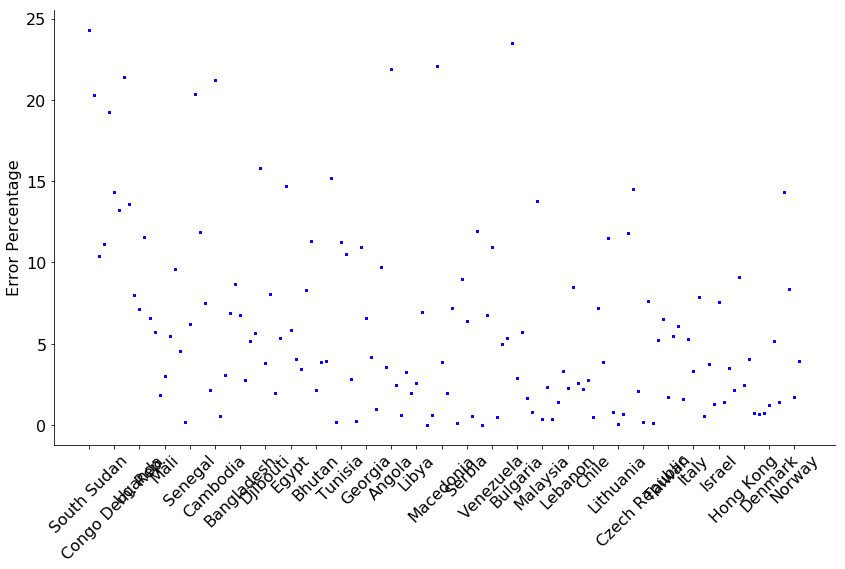

In [14]:
everyN = 5
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

results_sort = results.sort_values(by="lgdp") [["Location","gdp","error"]]

Y = results_sort[["error"]]
N = results_sort["Location"].values
X = range(1, results_sort.shape[0]+1)

plt.figure(figsize=(14, 8)) 

ax = plt.subplot(111) 
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()  

#ax.plot_date(X1,Y1)
#ax.plot(X,Y)
ax.scatter(X, Y, color='b', marker="s", s=2) #, label="Error Percentage")

#plt.xlabel("Time", fontsize=16)
plt.ylabel("Error Percentage", fontsize=16)

plt.xticks(X[::everyN], N[::everyN], fontsize=16, rotation="45")
plt.yticks(fontsize=16)

#plt.ylim(-1000, 3000)

#ax.legend(loc='upper right', ncol=1, fancybox=False, shadow=True, fontsize=15)

#plt.savefig("plt_%s.pdf" % (mesaid), bbox_inches="tight")




'\nXlabel = 15 #40\nYlabel = 70000 #120000\nax.text(Xlabel, Ylabel, "R2=%.2f" % (r2), size=18, color=\'k\', alpha=0.7) #, rotation=-15)\nax.text(Xlabel, Ylabel - 10000, "MAE=%.2f" % (mae), size=18, color=\'k\', alpha=0.7) #, rotation=-15)\nax.text(Xlabel, Ylabel - 20000, "%d Countries" % (countries), size=18, color=\'k\', alpha=0.7) #, rotation=-15)\n\nax.legend(loc=\'upper left\', ncol=1, fancybox=False, shadow=True, fontsize=15)\n'

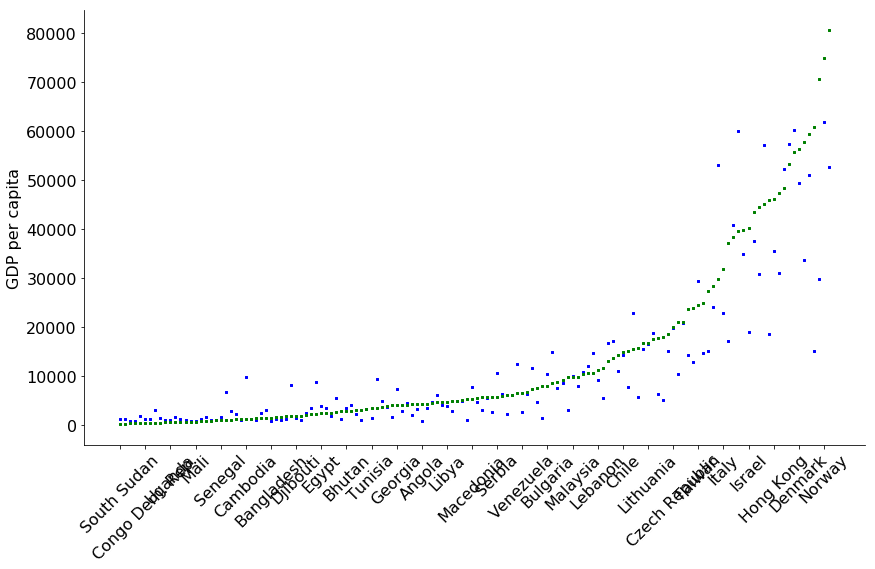

In [15]:
everyN = 5
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

results_sort = results.sort_values(by="lgdp") [["Location","gdp","pred","epred","lgdp"]]

Y_pred = results_sort["epred"].values
Y_gdp = results_sort["gdp"].values
N = results_sort["Location"].values
X = range(1, results_sort.shape[0]+1)

plt.figure(figsize=(14, 8)) 

ax = plt.subplot(111) 
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()  

#ax.plot_date(X1,Y1)
#ax.plot(X,Y)
ax.scatter(X, Y_pred, color='b', marker="s", s=2, label="Predictions")
ax.scatter(X, Y_gdp, color='g', marker="s", s=2, label="GDP per capita")


#plt.xlabel("Time", fontsize=16)
plt.ylabel("GDP per capita", fontsize=16)

plt.xticks(X[::everyN], N[::everyN], fontsize=16, rotation="45")
plt.yticks(fontsize=16)
"""
Xlabel = 15 #40
Ylabel = 70000 #120000
ax.text(Xlabel, Ylabel, "R2=%.2f" % (r2), size=18, color='k', alpha=0.7) #, rotation=-15)
ax.text(Xlabel, Ylabel - 10000, "MAE=%.2f" % (mae), size=18, color='k', alpha=0.7) #, rotation=-15)
ax.text(Xlabel, Ylabel - 20000, "%d Countries" % (countries), size=18, color='k', alpha=0.7) #, rotation=-15)

ax.legend(loc='upper left', ncol=1, fancybox=False, shadow=True, fontsize=15)
"""
#plt.savefig("plt_%s.pdf" % (mesaid), bbox_inches="tight")


In [136]:
results_sort[["gdp", "epred"]].corr("pearson")["gdp"]["epred"], results_sort[["gdp", "epred"]].corr("kendall")["gdp"]["epred"]


(0.8827084611255721, 0.6975327140145838)

Text(0.5,0,'GDP')

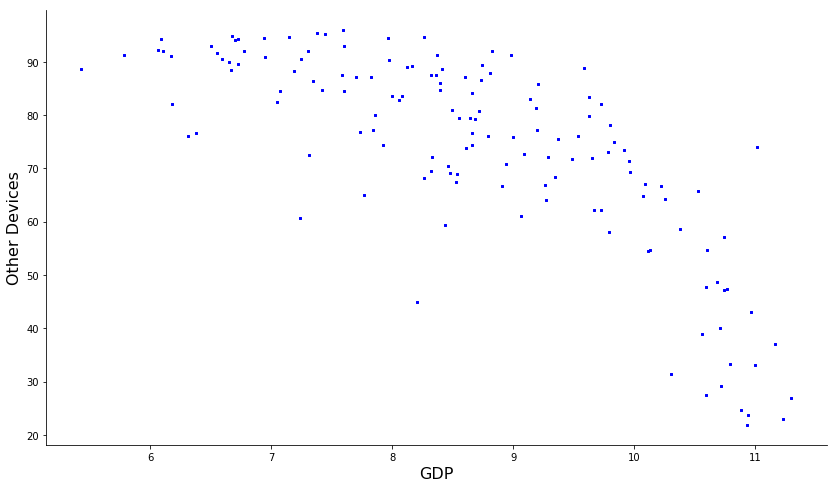

In [16]:
everyN = 5
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Y = postfilter["%audience_Other Devices"].values
X = np.log(postfilter["gdp"].values)
#X = range(1, results_sort.shape[0]+1)

plt.figure(figsize=(14, 8)) 

ax = plt.subplot(111) 
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()  

ax.scatter(X, Y, color='b', marker="s", s=2, label="Predictions")

#plt.xticks(X[::everyN], N[::everyN], fontsize=16, rotation="45")
plt.ylabel("Other Devices", fontsize=16)
plt.xlabel("GDP", fontsize=16)

#Xlabel = 15 #40
#Ylabel = 70000 #120000
#ax.text(Xlabel, Ylabel, "R2=%.2f" % (r2), size=18, color='k', alpha=0.7) #, rotation=-15)
#ax.text(Xlabel, Ylabel - 10000, "MAE=%.2f" % (mae), size=18, color='k', alpha=0.7) #, rotation=-15)
#ax.text(Xlabel, Ylabel - 20000, "%d Countries" % (countries), size=18, color='k', alpha=0.7) #, rotation=-15)

#ax.legend(loc='upper left', ncol=1, fancybox=False, shadow=True, fontsize=15)

#plt.savefig("plt_%s.pdf" % (mesaid), bbox_inches="tight")


In [17]:
r = results.sort_values(by="error", ascending=False) [["Location","lgdp","pred","error"]].reset_index(drop=True).head(200)
print(tabulate(r, headers='keys', tablefmt='psql'))


+-----+------------------------+----------+----------+------------+
|     | Location               |     lgdp |     pred |      error |
|-----+------------------------+----------+----------+------------|
|   0 | South Sudan            |  5.42935 |  7.17396 | 24.3187    |
|   1 | Gabon                  |  8.98369 |  7.27412 | 23.5021    |
|   2 | Namibia                |  8.59656 |  7.0417  | 22.0808    |
|   3 | Angola                 |  8.39118 |  6.88256 | 21.9194    |
|   4 | Yemen                  |  6.31173 |  8.02767 | 21.3753    |
|   5 | Cambodia               |  7.23706 |  9.18891 | 21.2414    |
|   6 | Kyrgyzstan             |  7.04229 |  8.84062 | 20.3417    |
|   7 | Malawi                 |  5.78074 |  7.25487 | 20.3191    |
|   8 | Madagascar             |  6.10479 |  7.56109 | 19.2605    |
|   9 | India                  |  7.59237 |  9.01527 | 15.7833    |
|  10 | Cape Verde             |  8.08271 |  7.01846 | 15.1636    |
|  11 | Vietnam                |  7.76387 |  9.1

# Predictions for Brazil

In [266]:

infile = "collections/pibbrasil/dataframe_collected_finished_1544338586.csv.gz"
infile = "collections/pibbrasil/dataframe_collected_finished_1544347742.csv.gz"
infile = "collections/pibbrasil/dataframe_collected_finished_1544349032.csv.gz"

df = pd.read_csv(infile)
df[["MinAge","MaxAge","Location","LocationHierarchy","LocationType","Gender","Relationship","Education","Group"]] = df["targeting"].apply(lambda x : expand(ast.literal_eval(x))).apply(pd.Series)
transform_dataframe(df)
del df["Group"]

# Quick check to see if any value is invalid
df[df["mau_audience"] == 1000]

Adding information regarding devices...
Removing redundant cols
All Done!


,dau_audience,mau_audience,MinAge,MaxAge,Location,LocationHierarchy,LocationType,Gender,Relationship,Education,Device,AgeBucket
63,999,1000,13,None,"Planaltina, Brasilia (-15.6189, -47.6552)",Coordinates,home,both,None,None,Expensive Devices,all
64,570,1000,13,None,"Planaltina, Brasilia (-15.6189, -47.6552)",Coordinates,home,both,None,None,Mid-range Devices,all
67,399,1000,13,None,"Planaltina, Brasilia (-15.6189, -47.6552)",Coordinates,home,both,None,None,2G,all
94,499,1000,13,None,"(-15.8264, -47.9828)",Coordinates,home,both,None,None,2G,all
103,699,1000,13,None,"(-16.0199, -48.0388)",Coordinates,home,both,None,None,2G,all
108,666,1000,13,None,"(-15.6500, -47.7849)",Coordinates,home,both,None,None,Expensive Devices,all
109,399,1000,13,None,"(-15.6500, -47.7849)",Coordinates,home,both,None,None,Mid-range Devices,all
112,498,1000,13,None,"(-15.6500, -47.7849)",Coordinates,home,both,None,None,2G,all
117,997,1000,13,None,"(-15.7575, -47.7776)",Coordinates,home,both,None,None,Expensive Devices,all
118,777,1000,13,None,"(-15.7575, -47.7776)",Coordinates,home,both,None,None,Mid-range Devices,all


In [267]:

def df_for_group(df, group, frequency):

    dfdevices = {}
    dfcut = df[(df["Device"].apply(lambda x : x in devices)) & (df["AgeBucket"] == "all") & (df["LocationType"] == "home")].copy()
    
    dfdevices["mau"] = get_slice(dfcut, "Device", devices, frequency="mau")
    dfdevices["dau"] = get_slice(dfcut, "Device", devices, frequency="dau")
    
    calculate_percentages(dfdevices["mau"], main_devices, "%")
    calculate_percentages(dfdevices["dau"], main_devices, "%")
    
    if useInfra:
        calculate_percentages(dfdevices["mau"], infra, "%")
        calculate_percentages(dfdevices["dau"], infra, "%")

    freq = dfdevices[frequency]
    #print(freq.sort_values("Location").to_csv(index=False, sep="\t"))
    freq["devices_pop"] = freq["audience_Expensive Devices"] + freq["audience_Mid-range Devices"] + freq["audience_Other Devices"] + freq["audience_Cheap Devices"]
    
    if useInfra:
        if useWifi:
            freq["infra_pop"] = freq["audience_2G"] + freq["audience_3G"] + freq["audience_4G"] + freq["audience_Wifi"]
        else:
            freq["infra_pop"] = freq["audience_2G"] + freq["audience_3G"] + freq["audience_4G"] 
    
    # check if devices_pop == online_pop
    dfcut = df[(df["Device"].isnull()) & (df["AgeBucket"] == "all") & (df["LocationType"] == "home") ].copy()
    
    all_cut = dfcut[["Location", "LocationHierarchy", frequency + "_audience"]]
    all_cut.columns = ["Location","LocationHierarchy","online_pop"]

    df_test = pd.merge(freq, all_cut, on="Location", how="outer")
    #merged = pd.merge(mau, gdp)
    
    print("Before Exclusion:", df_test.shape)
    for d in devices:
        #print("Excluding: \n", ven_test[ven_test["audience_" + d] < 300]["Location"])
        if frequency == "dau":
            df_test = df_test[df_test["audience_" + d] >= 600]
        else: 
            df_test = df_test[df_test["audience_" + d] >= 1001]
    #ven_test = ven_test[ven_test["audience_Other Devices"] >= 2000]
    print("After Exclusion:", df_test.shape)
    return df_test

br_test = df_for_group(df, 'All', frequency=train_frequency)
cities = br_test[br_test["LocationHierarchy"] == "Coordinates"].copy()

br_test.head()

('Before Exclusion:', (72, 22))
('After Exclusion:', (57, 22))


,Location,audience_Expensive Devices,audience_Mid-range Devices,audience_Other Devices,audience_2G,audience_3G,audience_4G,audience_Wifi,audience_Cheap Devices,Frequency,...,%audience_Cheap Devices,%audience_Other Devices,%audience_2G,%audience_3G,%audience_4G,%audience_Wifi,devices_pop,infra_pop,LocationHierarchy,online_pop
0,"Jardins, Sao Paulo (-23.5677, -46.6598)",290000,200000,2100000,31000,690000,1300000,1400000,310000,Monthly,...,10.689655,72.413793,0.906168,20.169541,38.000585,40.923707,2900000,3421000,Coordinates,2800000
1,"Itaquera, Sao Paulo (-23.5365, -46.4676)",50000,37000,700000,11000,280000,400000,390000,72000,Monthly,...,8.381839,81.490105,1.017576,25.901943,37.002775,36.077706,859000,1081000,Coordinates,850000
2,"Copacabana, Rio de Janeiro (-22.9755, -43.2004)",42000,27000,140000,2400,56000,150000,140000,33000,Monthly,...,13.636364,57.851240,0.688863,16.073479,43.053961,40.183697,242000,348400,Coordinates,230000
3,"Complexo do Alemao, Rio de Janeiro (-22.8610, ...",21000,18000,380000,6700,150000,230000,190000,28000,Monthly,...,6.263982,85.011186,1.161783,26.010057,39.882088,32.946072,447000,576700,Coordinates,450000
4,"Eixao, Brasilia (-15.7911, -47.8913)",89000,68000,660000,15000,230000,530000,550000,90000,Monthly,...,9.922822,72.767365,1.132075,17.358491,40.000000,41.509434,907000,1325000,Coordinates,900000


In [268]:
gdpbr16 = pd.read_csv("pibnominal16.csv")
gdpbr16["GDP_USD"] = gdpbr16["GDP16_BRL"] / 3.7
gdpbr16["Location"] = gdpbr16["Location"].apply(lambda x: x + ", Brazil")
gdpbr16.head()

,idx,Location,GDP16_BRL,GDP_USD
0,1,"Distrito Federal, Brazil",79099,21378.108108
1,2,"Sao Paulo, Brazil",45542,12308.648649
2,3,"Rio de Janeiro, Brazil",38481,10400.270270
3,4,"Mato Grosso, Brazil",37462,10124.864865
4,5,"Santa Catarina, Brazil",37140,10037.837838


In [293]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics

merged = pd.merge(br_test, gdpbr16)

X = merged[["%audience_Other Devices", "%audience_Expensive Devices", "%audience_Mid-range Devices", "%audience_Cheap Devices", "%audience_Wifi", "%audience_2G", "%audience_3G", "%audience_4G"]].values
X_test_locations = merged["Location"].values
X_test_hierarchy = merged["LocationHierarchy"].values
y = merged[["GDP_USD"]]

model = LinearRegression()
model.fit(X, y)
merged["predictions"] = model.predict(X)

merged.head()[["Location", "GDP_USD", "predictions"]]
merged[["GDP_USD", "predictions"]].corr("pearson")


print "R2:", metrics.r2_score(merged["predictions"], merged["GDP_USD"])
print "MSE:", np.sqrt(metrics.mean_squared_error(merged["predictions"], merged["GDP_USD"]))
print "MAE:", metrics.mean_absolute_error(merged["predictions"], merged["GDP_USD"])

R2: 0.93406933390594
MSE: 961.3294271295886
MAE: 727.6735135135136


In [291]:
Xcities = cities[["%audience_Other Devices", "%audience_Expensive Devices", "%audience_Mid-range Devices", "%audience_Cheap Devices", "%audience_Wifi", "%audience_2G", "%audience_3G", "%audience_4G"]].values
cities["predictions"] = model.predict(Xcities)
cities[["Location", "predictions"]]

,Location,predictions
0,"Jardins, Sao Paulo (-23.5677, -46.6598)",23616.0
1,"Itaquera, Sao Paulo (-23.5365, -46.4676)",12160.0
2,"Copacabana, Rio de Janeiro (-22.9755, -43.2004)",44416.0
3,"Complexo do Alemao, Rio de Janeiro (-22.8610, ...",10688.0
4,"Eixao, Brasilia (-15.7911, -47.8913)",25216.0
5,"Lagos, Brasilia (-15.8182, -47.8334)",24576.0
6,"Ceilandia, Brasilia (-15.8212, -48.1123)",5120.0
8,"Savassi, Belo Horizonte (-19.9381, -43.9355)",20736.0
9,"Venda Nova, Belo Horizonte (-19.8136, -43.9616)",8192.0
18,"(-19.8629, -43.9759)",21504.0


In [274]:
cities["geo"] = cities["Location"].apply(lambda x : x.split("(")[1].strip(")").split(","))
cities["lat"] = cities["geo"].apply(lambda x : x[0])
cities["long"] = cities["geo"].apply(lambda x : x[1])
cities["name"] = cities["Location"].apply(lambda x : x.split("(")[0])

from folium.features import DivIcon
import branca.colormap as cm
colormap = cm.LinearColormap(['red', 'yellow', 'green'],vmin=cities["predictions"].min(), vmax=cities["predictions"].max())
colormap.caption = 'Predicted GDP nominal per capita (USD)'
cities["color"] = cities["predictions"].apply(lambda x : colormap(x))

m = folium.Map(location=[-20.01, -50.05], zoom_start=6, tiles='openstreetmap')
fg = folium.FeatureGroup("GDP per capita", overlay=True)

for row in cities[["Location", "lat", "long", "name", "predictions", "color"]].values:
    location, lat, long, name, pred, color = row[0], float(row[1]), float(row[2]), row[3], float(row[4]), row[5]
    folium.Circle(location=[lat, long], radius=3000, popup=folium.Popup("<H3> %s </H3> <h5> Predicted GDP: %.2f USD <\h5>" % (name, pred)),
                  color=color, fill_color='grey').add_to(m)
    #folium.map.Marker([lat, long], icon=DivIcon(icon_size=(150,36), icon_anchor=(0,0), html='<div style="font-size: 12pt">%s</div>' % "BlaBlaBla",)).add_to(m)
    
m.add_child(fg)

folium.LayerControl().add_to(m)

url = ("https://www.qcri.org/app/media/3480")
plugins.FloatImage(url, bottom=2, left=80).add_to(m)
colormap.add_to(m)

m.save('pib.html')

m

In [257]:
state_geo = "states_brazil.json"
m = folium.Map(location=[-15, -55], zoom_start=4.5, tiles='Mapbox Bright')

m.choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=merged,
    columns=['Location', 'predictions'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Prediction GDP nominal per capita'
)

l = folium.LayerControl().add_to(m)

m

In [259]:
state_geo = "states_brazil.json"
m = folium.Map(location=[-15, -55], zoom_start=4.5, tiles='Mapbox Bright')

m.choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=merged,
    columns=['Location', 'GDP_USD'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='GDP nominal per capita (USD)'
)

l = folium.LayerControl().add_to(m)

m